In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Calculo de similaridade
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from sklearn.metrics import jaccard_score

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define seed
SEED = 42

# Set the seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
torch.backends.cudnn.benchmark = False    # Disable if you want deterministic results

Feature_ambos = [
                #'L4_SRC_PORT',
                #'L4_DST_PORT',
                'PROTOCOL',
                #'L7_PROTO',
                'IN_BYTES',
                'IN_PKTS',
                'OUT_BYTES',
                'OUT_PKTS',
                #'TCP_FLAGS',
                #'CLIENT_TCP_FLAGS',
                #'SERVER_TCP_FLAGS',
                'FLOW_DURATION_MILLISECONDS',
                'DURATION_IN', 
                'DURATION_OUT',
                #'MIN_TTL', 
                #'MAX_TTL',
                'LONGEST_FLOW_PKT',
                #'SHORTEST_FLOW_PKT',
                #'MIN_IP_PKT_LEN', 
                'MAX_IP_PKT_LEN', 
                'SRC_TO_DST_SECOND_BYTES', 
                'DST_TO_SRC_SECOND_BYTES',
                'RETRANSMITTED_IN_BYTES', 
                'RETRANSMITTED_IN_PKTS', 
                'RETRANSMITTED_OUT_BYTES', 
                'RETRANSMITTED_OUT_PKTS',
                'SRC_TO_DST_AVG_THROUGHPUT', 
                'DST_TO_SRC_AVG_THROUGHPUT', 
                'NUM_PKTS_UP_TO_128_BYTES',
                'NUM_PKTS_128_TO_256_BYTES', 
                'NUM_PKTS_256_TO_512_BYTES', 
                'NUM_PKTS_512_TO_1024_BYTES',
                'NUM_PKTS_1024_TO_1514_BYTES', 
                #'TCP_WIN_MAX_IN', 
                #'TCP_WIN_MAX_OUT', 
                'ICMP_TYPE', 
                'ICMP_IPV4_TYPE',
                #'DNS_QUERY_ID', 
                'DNS_QUERY_TYPE', 
                #'DNS_TTL_ANSWER',
                #'FTP_COMMAND_RET_CODE',
                'Label', 
                'Attack']

Feature_name = [f for f in Feature_ambos if f not in ['Label', 'Attack']]

input_dim = 26

# Mapear todos os ataques
map_attacks = {'Benign':0, 
              'DoS':1,
              'dos':1,
              'Reconnaissance':2,
              'DDoS':3,
              'ddos':3,
              'Theft':4,
              'ransomware':5,
              'scanning':6,
              'xss':7,
              'mitm':8,
              'password':9,
              'Backdoor':10,
              'backdoor':10,
              'Analysis':11,
              'Generic':12,
              'Exploits':13,
              'Bot':14,
              'DoS_attacks-SlowHTTPTest':15,
              'SSH-Bruteforce':16,
              'DoS_attacks-Hulk':17,
              'Infilteration':18,
              'DDOS_attack-HOIC':19, 
              'FTP-BruteForce':20,
              'Brute_Force_-Web':21, 
              'DDoS_attacks-LOIC-HTTP':22, 
              'DoS_attacks-GoldenEye':23,
              'DDOS_attack-LOIC-UDP':24, 
              'DoS_attacks-Slowloris':25, 
              'Brute_Force_-XSS':26,
              'SQL_Injection':27
              }

In [2]:
class AE1(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(AE1, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim), nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x_enc = self.encoder(x)
        recon = self.decoder(x_enc)
        return recon, x_enc

In [3]:
class AE2(nn.Module):
    def __init__(self, input_dim, latent_dim=32, dropout_rate=0.2):
        super(AE2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(512, 256), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(256, 128), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(128, 64), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(64, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(64, 128), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(128, 256), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(256, 512), nn.PReLU(), nn.Dropout(dropout_rate),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x_enc = self.encoder(x)
        recon = self.decoder(x_enc)
        return recon, x_enc

In [4]:
class AE3(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(AE3, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim), nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        x_enc = self.encoder(x)
        recon = self.decoder(x_enc)
        return recon, x_enc

In [5]:
def ae_loss(recon_x, x):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss

In [6]:
class MLP(nn.Module):
    def __init__(self, latent_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(64, 28),
            #nn.Softmax()
        )

    def forward(self, x):
        return self.mlp(x)

In [7]:
def get_datasets(dataset):
    
    if dataset == "dataset1":
         df = pd.read_csv('datasets/dataset1v2.csv') # NF-BoT-IoT-v2
    if dataset == "dataset2":
         df = pd.read_csv('datasets/dataset2v2.csv') # NF-ToN-IoT-v2
    if dataset == "dataset3":
         df = pd.read_csv('datasets/dataset3v2.csv') # NF-UNSW-NB15-v2
    if dataset == "dataset4":
         df = pd.read_csv('datasets/dataset4v2.csv') # NF-CICIDS2018-v3

    dataframe = df[Feature_ambos]
    
    return dataframe

In [8]:
def preprocessing_data(df):
    df_split = df.copy()
    df_split_label = df_split['Attack']
    df_split = df_split.drop('Attack',axis=1)
    df_split = df_split.drop('Label',axis=1)
    
    # Inicializando o MinMaxScaler (intervalo padrão é [0, 1])
    scaler = MinMaxScaler()

    # Ajustando e transformando os dados
    df_split = scaler.fit_transform(df_split)
    
    df_split_label = df_split_label.to_frame()
    x_split_train, x_split_temp, y_split_train, y_split_temp = train_test_split(df_split, df_split_label, test_size = 0.30, stratify=df_split_label)
    x_split_test, x_split_val, y_split_test, y_split_val = train_test_split(x_split_temp, y_split_temp, test_size = 0.50, stratify=y_split_temp)
    #y_split_train['Attack'] = y_split_train['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    z_split_test = y_split_test.copy()
    #y_split_test['Attack'] = y_split_test['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    #print(z_split_test)
    y_split_train['Attack']=y_split_train['Attack'].map(map_attacks)
    y_split_test['Attack']=y_split_test['Attack'].map(map_attacks)
    y_split_val['Attack']=y_split_val['Attack'].map(map_attacks)
    #z_test = torch.tensor(np.array(z_split_test, dtype=np.float32), dtype = torch.float)
    class_test = torch.tensor(np.array(y_split_test, dtype=np.float32), dtype = torch.float)
    class_attack = torch.tensor(np.array(y_split_test, dtype=np.float32), dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(class_attack, class_test)
    z_test = torch.utils.data.DataLoader(dataset, batch_size=100)
    #print(z_split_test)
    #y_split_val['Attack'] = y_split_val['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    return x_split_train, y_split_train, x_split_val, y_split_val, x_split_test, y_split_test, z_test

In [9]:
def tensor_data(x_source1_train, y_source1_train):
    previsores_train = torch.tensor(np.array(x_source1_train), dtype = torch.float)
    class_train = torch.tensor(np.array(y_source1_train, dtype=np.float32), dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(previsores_train, class_train)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
    return previsores_train, class_train, dataset, train_loader

In [10]:
def inicia_datasets(treino):
      df = get_datasets(treino)
      print(f"Prepara {treino}: {df.shape}")
      x_split_train, y_split_train, x_split_val, y_split_val, x_split_test, y_split_test, z_split_test = preprocessing_data(df)
      print( x_split_train.shape, y_split_train.shape)
      print( x_split_val.shape, y_split_val.shape)
      print( x_split_test.shape, y_split_test.shape)
      dataset_train, class_train, dataset_train, loader_train = tensor_data( x_split_train,  y_split_train)
      dataset_val, class_val, dataset_val, loader_val = tensor_data( x_split_val,  y_split_val)
      dataset_test, class_test, dataset_test, loader_test = tensor_data( x_split_test,  y_split_test)
      return dataset_train, class_train, dataset_train, loader_train, dataset_val, class_val, dataset_val, loader_val, dataset_test, class_test, dataset_test, loader_test, z_split_test

In [11]:
dataset = "dataset1" 
dataset_train1, class_train1, dataset_train1, loader_train1, dataset_val1, class_val1, dataset_val1, loader_val1, dataset_test1, class_test1, dataset_test1, loader_test1, z_split_test1 = inicia_datasets(dataset)
dataset = "dataset2" 
dataset_train2, class_train2, dataset_train2, loader_train2, dataset_val2, class_val2, dataset_val2, loader_val2, dataset_test2, class_test2, dataset_test2, loader_test2, z_split_test2 = inicia_datasets(dataset)
dataset = "dataset3" 
dataset_train3, class_train3, dataset_train3, loader_train3, dataset_val3, class_val3, dataset_val3, loader_val3, dataset_test3, class_test3, dataset_test3, loader_test3, z_split_test3 = inicia_datasets(dataset)
dataset = "dataset4" 
dataset_train4, class_train4, dataset_train4, loader_train4, dataset_val4, class_val4, dataset_val4, loader_val4, dataset_test4, class_test4, dataset_test4, loader_test4, z_split_test4 = inicia_datasets(dataset)

# Gerar ambos para teste e validação
test_dataset_combined = ConcatDataset([dataset_test1, dataset_test2, dataset_test3, dataset_test4])
test_loader_combined = DataLoader(test_dataset_combined, batch_size=loader_test1.batch_size, shuffle=True)
val_dataset_combined = ConcatDataset([dataset_val1, dataset_val2, dataset_val3, dataset_val4])
val_loader_combined = DataLoader(val_dataset_combined, batch_size=loader_val1.batch_size, shuffle=True)

Prepara dataset1: (224511, 28)
(157157, 26) (157157, 1)
(33677, 26) (33677, 1)
(33677, 26) (33677, 1)
Prepara dataset2: (224512, 28)
(157158, 26) (157158, 1)
(33677, 26) (33677, 1)
(33677, 26) (33677, 1)
Prepara dataset3: (142152, 28)
(99506, 26) (99506, 1)
(21323, 26) (21323, 1)
(21323, 26) (21323, 1)
Prepara dataset4: (223976, 28)
(156783, 26) (156783, 1)
(33597, 26) (33597, 1)
(33596, 26) (33596, 1)


In [12]:
def treina_modelo(modelo_AE1, modelo_AE2, modelo_AE3, modelo_MLP, input_dim, device):
    from sklearn.metrics import classification_report
    
    # Hiperparâmetros
    num_classes = 27  # Atualizando para 27 classes
    epochs = 600
    lr = 0.001

    Alpha = 0.2
    Beta = 1
    Gama = 0.2
    
    patience = 50
    best_val_acc = 0
    epochs_no_improve = 0
    best_model_state = None
  
    # Otimizador conjunto
    params = list(modelo_MLP.parameters()) + list(modelo_AE1.parameters()) + list(modelo_AE2.parameters()) + list(modelo_AE3.parameters())    
    optimizer = torch.optim.Adam(params, lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Scheduler: reduz o learning rate se a acurácia parar de melhorar
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5)

    # Histórico
    loss_vals = []
    loss_valsAE = []
    loss_valsAE2 = []
    loss_valsAE3 = []
    loss_valsMLP = []
    val_simC = []
    val_distE = []
    val_distM = []
    val_accuracies = []
    val_losses = []
    
    dissim_cos_12 = []
    dissim_euc_12 = []

    Z_AE1 = []
    Z_AE2 = []
    
    for epoch in range(epochs):
        
        modelo_AE1.train()
        modelo_AE2.train()
        modelo_AE3.train()
        modelo_MLP.train()
        
        epoch_loss_recon = []
        epoch_loss_class = []
        epoch_loss_val = []
        epoch_simC = []
        epoch_corr = []
        epoch_distE = []
        epoch_distM = []
        epoch_simJ = []
        
        # Variáveis para similaridade
        simC = 0  # Cosseno 
        corr = 0  # Pearson 1.0 Correlação perfeita
        distE = 0  #  Eculidiana - Distância euclidiana
        distM = 0  # Distância de Manhattan
        simJ = 0  # Similaridade de Jaccard (para vetores binários ou conjuntos)

        for (X1, y1), (X2, y2), (X3, y3), (X4, y4) in zip(loader_train1, loader_train2, loader_train3, loader_train4):
    
            X = torch.cat([X1, X2, X3, X4], dim=0).to(device)
            y = torch.cat([y1, y2, y3, y4], dim=0).to(device).long()  # Certifique-se de que y seja long
            y = y.squeeze()  # Garantir que y seja 1D
            
            optimizer.zero_grad()
            
            # Forward do VAE1, VAE2 e VAE3
            recon1, x_latent1 = modelo_AE1(X)
            recon2, x_latent2 = modelo_AE2(X)
            recon3, x_latent3 = modelo_AE3(X)

            # Perda de reconstrução
            recon_loss1 = ae_loss(recon1, X)
            recon_loss2 = ae_loss(recon2, X)
            recon_loss3 = ae_loss(recon3, X)

            # Classificação com vetor latente
            x_latent = torch.cat([x_latent1, x_latent2, x_latent3], dim=1)
            outputs = modelo_MLP(x_latent)

            # Calcular a perda de classificação
            loss_class = loss_fn(outputs, y)  # Passando diretamente o tensor y

            # Perda total
            loss_recon = (recon_loss1 + recon_loss2 + recon_loss3) / 3
            loss_diss = (F.mse_loss(x_latent1, x_latent2))

            total_loss = (loss_recon * Alpha) + (loss_class * Beta) + (loss_diss * Gama)

            total_loss.backward()
            optimizer.step()

            epoch_loss_recon.append(recon_loss1.item())
            epoch_loss_recon.append(recon_loss2.item())
            epoch_loss_recon.append(recon_loss3.item())
            epoch_loss_class.append(loss_class.item())

        # === Logs da época ===
        loss_epoch_recon = sum(epoch_loss_recon) / len(epoch_loss_recon)
        loss_epoch_class = sum(epoch_loss_class) / len(epoch_loss_class)
        
        loss_valsAE.append(loss_epoch_recon)
        loss_valsMLP.append(loss_epoch_class)
        
        print(f"Epoch {epoch+1:02d}/{epochs} | Recon: {loss_epoch_recon:.4f} | Class: {loss_epoch_class:.4f}")
        
        modelo_AE1.eval()
        modelo_AE2.eval()
        modelo_AE3.eval()
        modelo_MLP.eval()
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            
           for (X1, y1), (X2, y2), (X3, y3), (X4, y4) in zip(loader_val1, loader_val2, loader_val3, loader_val4):
    
               X = torch.cat([X1, X2, X3, X4], dim=0).to(device)
               y = torch.cat([y1, y2, y3, y4], dim=0).to(device).long()  # Certifique-se de que y seja long
               y = y.squeeze()  # Garantir que y seja 1D

               optimizer.zero_grad()
            
               # Forward do VAE1, VAE2 e VAE3
               recon1, x_latent1 = modelo_AE1(X)
               recon2, x_latent2 = modelo_AE2(X)
               recon3, x_latent3 = modelo_AE3(X)
            
               # Classificação com vetor latente
               x_latent = torch.cat([x_latent1, x_latent2, x_latent3], dim=1)
               outputs = modelo_MLP(x_latent)
               _, preds = torch.max(outputs, 1)
               
               #epoch_loss_val.append(loss.item())
               
               all_preds.append(preds)
               all_labels.append(y)

        all_preds_list = torch.cat(all_preds)
        all_labels_list = torch.cat(all_labels)
        print(f"Predictions shape: {all_preds_list.shape}")
        print(f"Labels shape: {all_labels_list.shape}")
        
        acc = (all_preds_list.view(-1) == all_labels_list.view(-1)).float().mean().item()
        #loss_val = sum(epoch_loss_val) / len(epoch_loss_val)
    
        val_accuracies.append(acc)
        #val_losses.append(loss_val)
        print(f"Acurácia: {acc}")

        # Atualiza scheduler com base na acurácia de validação
        scheduler.step(acc)

        # Mostra o learning rate atual
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print(f"Learning Rate atual: {current_lr:.6f}")        

        # Early stopping
        if acc > best_val_acc:
            best_val_acc = acc
            epochs_no_improve = 0
            best_model_state = modelo_MLP.state_dict()
        else:
            epochs_no_improve += 1
            print(f"Sem melhoria na validação por {epochs_no_improve} época(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping ativado na época {epoch+1}")
                break

    # Restaurar melhor modelo
    if best_model_state is not None:
        modelo_MLP.load_state_dict(best_model_state)
        print("Melhor modelo MLP restaurado com base na menor perda de validação.")  
    
    return  all_preds, all_labels



In [13]:
# Instanciando o modelo
latent_dim = 96
modelo_AE1 = AE1(input_dim)
modelo_AE2 = AE2(input_dim)
modelo_AE3 = AE3(input_dim)
modelo_MLP = MLP(latent_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
import time 

start = time.time()
train_preds, train_labels = treina_modelo(modelo_AE1, modelo_AE2, modelo_AE3, modelo_MLP, input_dim, device)
end = time.time()
tempo = end - start
print("Tempo de execução: ", tempo)

import psutil
import os

process = psutil.Process(os.getpid())
print("Memória usada (MB):", process.memory_info().rss / 1024**2)

Epoch 01/600 | Recon: 15.0228 | Class: 1.2180
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.6857219934463501
Learning Rate atual: 0.001000
Epoch 02/600 | Recon: 2.6481 | Class: 0.8019
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.7331477999687195
Learning Rate atual: 0.001000
Epoch 03/600 | Recon: 1.9717 | Class: 0.7048
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.7509675621986389
Learning Rate atual: 0.001000
Epoch 04/600 | Recon: 1.6566 | Class: 0.6409
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.786934494972229
Learning Rate atual: 0.001000
Epoch 05/600 | Recon: 1.4695 | Class: 0.5990
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.7780362963676453
Learning Rate atual: 0.001000
Sem melhoria na validação por 1 época(s).
Epoch 06/600 | Recon: 1.3838 | Class: 0.5708
Predictions shape: torch.Siz

Epoch 41/600 | Recon: 0.6682 | Class: 0.3098
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.7444664239883423
Learning Rate atual: 0.000500
Sem melhoria na validação por 8 época(s).
Epoch 42/600 | Recon: 0.6717 | Class: 0.3081
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.7600294947624207
Learning Rate atual: 0.000500
Sem melhoria na validação por 9 época(s).
Epoch 43/600 | Recon: 0.6693 | Class: 0.3064
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.8651824593544006
Learning Rate atual: 0.000500
Sem melhoria na validação por 10 época(s).
Epoch 44/600 | Recon: 0.6704 | Class: 0.3075
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.8726775050163269
Learning Rate atual: 0.000250
Sem melhoria na validação por 11 época(s).
Epoch 45/600 | Recon: 0.6074 | Class: 0.2964
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acur

Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9009155631065369
Learning Rate atual: 0.000250
Sem melhoria na validação por 4 época(s).
Epoch 81/600 | Recon: 0.5605 | Class: 0.2724
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.8448137044906616
Learning Rate atual: 0.000250
Sem melhoria na validação por 5 época(s).
Epoch 82/600 | Recon: 0.5584 | Class: 0.2750
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9010558724403381
Learning Rate atual: 0.000250
Sem melhoria na validação por 6 época(s).
Epoch 83/600 | Recon: 0.5493 | Class: 0.2740
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9030202627182007
Learning Rate atual: 0.000250
Epoch 84/600 | Recon: 0.5532 | Class: 0.2727
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9039322733879089
Learning Rate atual: 0.000250
Epoch 85/600 | Recon: 0.5628 | Cla

Epoch 119/600 | Recon: 0.5107 | Class: 0.2589
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.8826046586036682
Learning Rate atual: 0.000063
Sem melhoria na validação por 11 época(s).
Epoch 120/600 | Recon: 0.4925 | Class: 0.2534
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9070425629615784
Learning Rate atual: 0.000063
Sem melhoria na validação por 12 época(s).
Epoch 121/600 | Recon: 0.4978 | Class: 0.2536
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9063175916671753
Learning Rate atual: 0.000063
Sem melhoria na validação por 13 época(s).
Epoch 122/600 | Recon: 0.4932 | Class: 0.2531
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.905604362487793
Learning Rate atual: 0.000063
Sem melhoria na validação por 14 época(s).
Epoch 123/600 | Recon: 0.4900 | Class: 0.2538
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523]

Epoch 157/600 | Recon: 0.4760 | Class: 0.2477
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9091355800628662
Learning Rate atual: 0.000016
Sem melhoria na validação por 17 época(s).
Epoch 158/600 | Recon: 0.4794 | Class: 0.2479
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9094278812408447
Learning Rate atual: 0.000016
Sem melhoria na validação por 18 época(s).
Epoch 159/600 | Recon: 0.4772 | Class: 0.2464
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9093109369277954
Learning Rate atual: 0.000016
Sem melhoria na validação por 19 época(s).
Epoch 160/600 | Recon: 0.4795 | Class: 0.2476
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9085392355918884
Learning Rate atual: 0.000016
Sem melhoria na validação por 20 época(s).
Epoch 161/600 | Recon: 0.4821 | Class: 0.2466
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523

Epoch 195/600 | Recon: 0.4698 | Class: 0.2460
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9096851348876953
Learning Rate atual: 0.000002
Sem melhoria na validação por 33 época(s).
Epoch 196/600 | Recon: 0.4719 | Class: 0.2439
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9092174172401428
Learning Rate atual: 0.000002
Sem melhoria na validação por 34 época(s).
Epoch 197/600 | Recon: 0.4747 | Class: 0.2458
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9088432192802429
Learning Rate atual: 0.000002
Sem melhoria na validação por 35 época(s).
Epoch 198/600 | Recon: 0.4712 | Class: 0.2444
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9099072813987732
Learning Rate atual: 0.000002
Sem melhoria na validação por 36 época(s).
Epoch 199/600 | Recon: 0.4699 | Class: 0.2462
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523

Epoch 233/600 | Recon: 0.4720 | Class: 0.2445
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9085041284561157
Learning Rate atual: 0.000000
Sem melhoria na validação por 22 época(s).
Epoch 234/600 | Recon: 0.4655 | Class: 0.2449
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9098604917526245
Learning Rate atual: 0.000000
Sem melhoria na validação por 23 época(s).
Epoch 235/600 | Recon: 0.4902 | Class: 0.2460
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9098488092422485
Learning Rate atual: 0.000000
Sem melhoria na validação por 24 época(s).
Epoch 236/600 | Recon: 0.4710 | Class: 0.2447
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523])
Acurácia: 0.9089601635932922
Learning Rate atual: 0.000000
Sem melhoria na validação por 25 época(s).
Epoch 237/600 | Recon: 0.4689 | Class: 0.2456
Predictions shape: torch.Size([85523])
Labels shape: torch.Size([85523

In [35]:
def testa(target_test, treino, labels_test):
    # Define o modelo para modo de avaliação
    modelo_AE1.eval()
    modelo_AE2.eval()
    modelo_AE3.eval()
    modelo_MLP.eval()
    loss_fn = nn.CrossEntropyLoss()
    
    all_preds, all_labels, all_attacks = [], [], []
    
    # Loop para avaliar os dados de teste
    for (X, y), (z, y2) in zip(target_test, labels_test):
        
        X = X.to(device)
        y = y.squeeze()
        y = y.to(device).float()
        z = z.to(device).float()
        
        # Forward pass para os Autoencoders
        recon1, x_latent1 = modelo_AE1(X)
        recon2, x_latent2 = modelo_AE2(X)
        recon3, x_latent3 = modelo_AE3(X)
        
        # Classificação com vetor latente combinado
        x_latent = torch.cat([x_latent1, x_latent2, x_latent3], dim=1)
        outputs = modelo_MLP(x_latent)
        
        # Calcula a perda de classificação usando CrossEntropyLoss
        loss_class = loss_fn(outputs, y.long().to(device))
        
        # Calcula as previsões (classe com maior probabilidade)
        preds = torch.argmax(outputs, dim=1)
        
        # Adiciona as previsões e rótulos à lista
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())
        all_attacks.append(z.cpu())
    
    # Concatenando todas as previsões e rótulos
    all_preds_list = torch.cat(all_preds)
    all_labels_list = torch.cat(all_labels)
    all_attacks_list = torch.cat(all_attacks)

    # Cálculo da acurácia geral
    acc = (all_preds_list == all_labels_list).float().mean().item()

    # Matriz de Confusão
    matriz2 = confusion_matrix(all_labels_list.numpy(), all_preds_list.numpy())
    sns.set(rc={"figure.figsize": (8, 6)})
    title = "Matriz de Confusão: " + treino
    sns.heatmap(matriz2 / np.sum(matriz2), annot=True, annot_kws={'size': 10}, fmt='.2%', cmap='Blues').set_title(title)
    plt.show()

    # Cálculo das métricas por classe
    TPR = []  # Sensibilidade (Recall)
    TNR = []  # Especificidade
    ACC_class = []  # Acurácia por classe

    for i in range(matriz2.shape[0]):
      TP = matriz2[i, i]
      FP = matriz2[:, i].sum() - TP
      FN = matriz2[i, :].sum() - TP
      TN = matriz2.sum() - (TP + FP + FN)
 
      # Métricas
      TPR.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
      TNR.append(TN / (TN + FP) if (TN + FP) != 0 else 0)
      ACC_class.append((TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0)

    # Médias
    TPR_mean = np.mean(TPR)
    TNR_mean = np.mean(TNR)
    ACC_mean = np.mean(ACC_class)

    # Exibir resultados
    print("\n=== Métricas por Classe ===")
    for i, (tpr, tnr, acc_c) in enumerate(zip(TPR, TNR, ACC_class)):
       print(f"Classe {i}: TPR={tpr:.3f}, TNR={tnr:.3f}, Acc={acc_c:.3f}")

    print("\n=== Médias Gerais ===")
    print(f"Acurácia geral: {acc:.3f}")
    print(f"TPR médio: {TPR_mean:.3f}")
    print(f"TNR médio: {TNR_mean:.3f}")
    print(f"Acurácia média por classe: {ACC_mean:.3f}")
    
    # Cálculo da métrica F1 para multiclasse (micro e macro average)
    F1 = f1_score(all_labels_list.numpy(), all_preds_list.numpy(), average='weighted')  # Usando média ponderada

    return TPR_mean, TNR_mean, F1, acc, all_preds_list.view(-1), all_labels_list.view(-1), all_attacks_list.view(-1)

Treinando com Ambos e validando com dataset1


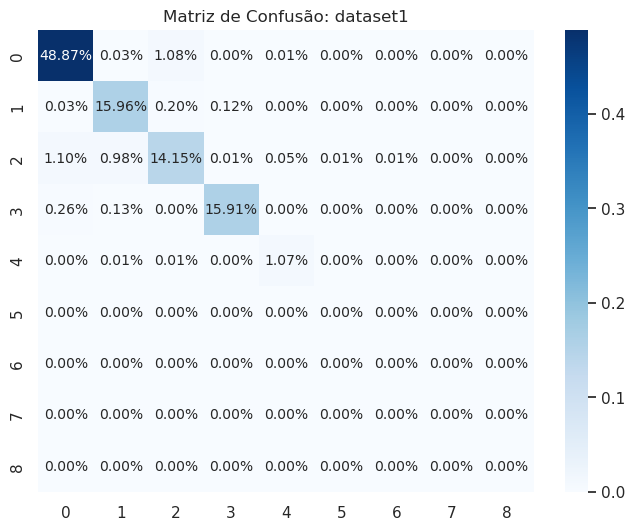

Treinando com Ambos e validando com dataset2


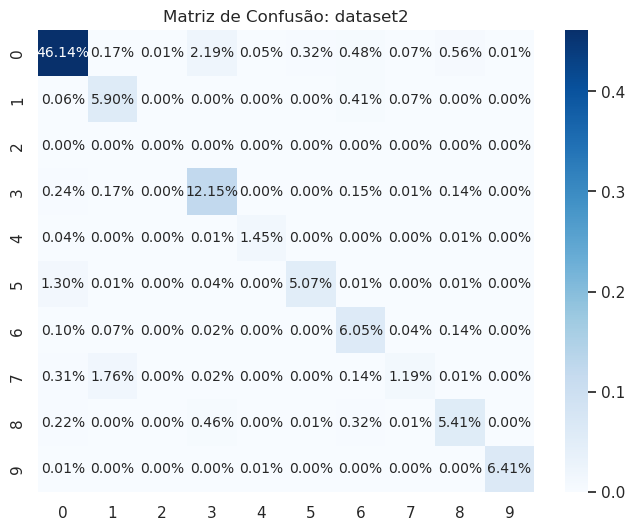

Treinando com Ambos e validando com dataset3


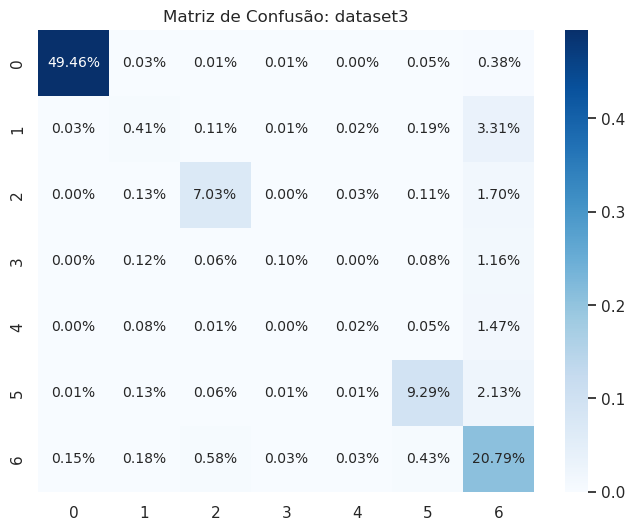

Treinando com Ambos e validando com dataset4


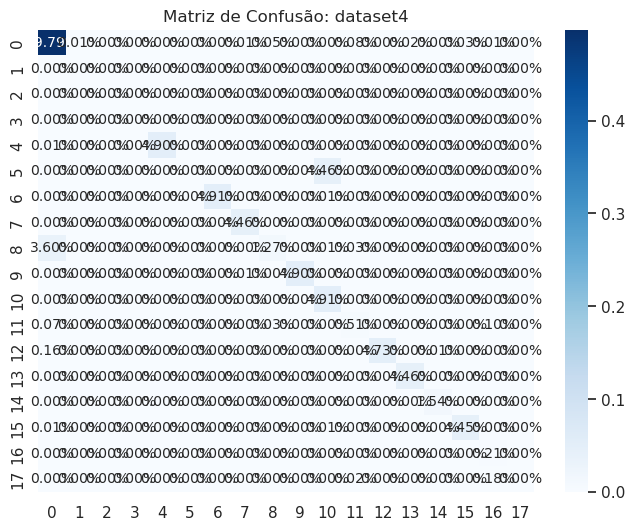

----------------------------------------------
Resumo da validação nos Datasets:
    Dataset       TPR       TNR  F1-Score  Acurácia
0  dataset1  0.531762  0.993397  0.959387  0.959527
1  dataset2  0.764857  0.986750  0.894863  0.897764
2  dataset3  0.526468  0.976820  0.852539  0.870984
3  dataset4  0.662330  0.992755  0.885005  0.910555
----------------------------------------------


In [27]:
datasets = ["dataset1", "dataset2", "dataset3", "dataset4"]
target_test = [loader_test1, loader_test2, loader_test3, loader_test4]
labels_test = [z_split_test1, z_split_test2, z_split_test3, z_split_test4]

TPRs = []
TNRs = []
F1s = []
ACCs = []
all_preds_lists = []
all_labels_lists = []
all_attacks_lists = []

for data, teste, labels  in zip(datasets, target_test, labels_test):
    print(f"Treinando com Ambos e validando com {data}")
    TPR, TNR, F1, acc, all_preds_list, all_labels_list, all_attacks_list = testa(teste, data, labels)
    TPRs.append(TPR)
    TNRs.append(TNR)
    F1s.append(F1)
    ACCs.append(acc)
    all_preds_lists.extend(all_preds_list)
    all_labels_lists.extend(all_labels_list)
    all_attacks_lists.extend(all_attacks_list)
    
# Criação da tabela
df = pd.DataFrame({
    'Dataset': datasets,
    'TPR': TPRs,
    'TNR': TNRs,
    'F1-Score': F1s,
    'Acurácia': ACCs
})
print("----------------------------------------------")
print("Resumo da validação nos Datasets:")
print(df)
print("----------------------------------------------")

In [30]:
# Combinar todas as predições em um dataframe para tabulação

all_labels = [t.item() for t in all_labels_lists]
all_preds = [t.item() for t in all_preds_lists]
all_attacks = [t.item() for t in all_attacks_lists]

# Inverter dicionario
map_attacks_inv = {v: k for k, v in map_attacks.items()}

df = pd.DataFrame({
    "Real": all_labels,
    "Previsto": all_preds,
    "Ataque": all_attacks
})

# Criar coluna de acerto/erro
df["Acertou"] = df["Real"] == df["Previsto"]

# Agrupar predições por tipo de ataque
tabela = df.groupby("Ataque").agg(
    Total=("Real","count"),
    Acertos=("Acertou","sum")
)

# Adicionar Acurácia por ataque
tabela["Acurácia"] = tabela["Acertos"] / tabela["Total"]

# Adicionar F1 por ataque
f1_por_ataque = {}
TP_por_ataque = {}
TN_por_ataque = {}
FP_por_ataque = {}
FN_por_ataque = {}

for atk, grupo in df.groupby("Ataque"):
    TP_por_ataque[atk] = ((grupo["Real"] == 1) & (grupo["Previsto"] == 1)).sum()
    TN_por_ataque[atk] = ((grupo["Real"] == 0) & (grupo["Previsto"] == 0)).sum()
    FP_por_ataque[atk] = ((grupo["Real"] == 0) & (grupo["Previsto"] == 1)).sum()
    FN_por_ataque[atk] = ((grupo["Real"] == 1) & (grupo["Previsto"] == 0)).sum()

for atk, grupo in df.groupby("Ataque"):
    f1_por_ataque[atk] = f1_score(
        grupo["Real"], grupo["Previsto"],
        average="weighted",   # ou "macro"
        zero_division=0
    )
    
tabela["TP"] = tabela.index.map(TP_por_ataque)
tabela["TN"] = tabela.index.map(TN_por_ataque)
tabela["FP"] = tabela.index.map(FP_por_ataque)
tabela["FN"] = tabela.index.map(FN_por_ataque)
tabela["F1"] = tabela.index.map(f1_por_ataque)


# Renomear indice pelo nome do ataque
tabela.index = tabela.index.map(map_attacks_inv)

print("Resumo por tipo de ataque:")
print(tabela)

Resumo por tipo de ataque:
                          Total  Acertos  Acurácia    TP     TN  FP  FN  \
Ataque                                                                    
Benign                    61125    55845  0.913620  3679  29653  28  22   
dos                        8527     8008  0.939135  1016   4167   6   3   
Reconnaissance             7409     6917  0.933594   903   3661   2   0   
ddos                       9825     9166  0.932926  1136   4662  13   4   
Theft                       364      351  0.964286    64    168   1   0   
ransomware                  514      460  0.894942    23    256   1   0   
scanning                   2166     1949  0.899815   139    982   1   1   
xss                        2167     1932  0.891555   132    976   4   0   
mitm                       1158     1017  0.878238    41    534   4   2   
password                   2167     1936  0.893401   135   1001   3   0   
backdoor                   2491     2236  0.897631   142   1136   8   1  